In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import (metrics, model_selection, linear_model, preprocessing, ensemble, neighbors, tree)
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pydotplus
import seaborn as sns
import numpy as np
import pandas as pd
import pprint as pp
import re
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier,plot_tree,to_graphviz
from IPython.display import Image 

%matplotlib inline

# markdown syntax:
# https://daringfireball.net/projects/markdown/syntax#header

In [10]:
import txdot_parse as txpars
import helpers

# Introduction

# Data Preparation

## Preprocessing

In [4]:
# import the "crash" data
data = pd.read_csv("my_map_grid.csv",header=10)

In [5]:
# preprocessing
# lowercase: http://stackoverflow.com/a/38931854
data.columns = data.columns.str.lower()
# remove spaces
data.columns = data.columns.str.replace(' ', '_')
# special cases
data.columns = data.columns.str.replace('crash_i_d', 'crash_id')
# remove whateva data

# replace ['No Data','Not Applicable'] with NaN
data.replace(to_replace='No Data', value=np.nan, inplace=True)
data.replace(to_replace='Not Applicable', value=np.nan, inplace=True)
data.latitude = pd.to_numeric(data.latitude)
data.longitude = pd.to_numeric(data.longitude)

## Impute Missing Values

In [6]:
data.speed_limit.replace(0,np.nan,inplace=True)
data.speed_limit.replace(-1,np.nan,inplace=True)
# impute speed limits
print("########################################")
verbose=0
if(verbose):
    print(data.speed_limit.value_counts())
totalmissing   = data[data['speed_limit'].isnull()].shape[0]
missingpercent = totalmissing / data.shape[0]
print("pre : total missing speed limit data:\n %s (%s of 1)" % (totalmissing, missingpercent))
if(verbose):
    print(data.speed_limit.unique())
data = txpars.impute_mph(data, verbose=0)
totalmissing   = data[data['speed_limit'].isnull()].shape[0]
missingpercent = totalmissing / data.shape[0]
print("post: total missing speed limit data:\n %s (%s of 1)" % (totalmissing, missingpercent))
if(verbose):
    print(data.speed_limit.unique())
    print(data.speed_limit.value_counts())
    print(data.info())
print("########################################")

########################################
pre : total missing speed limit data:
 575 (0.2576164874551971 of 1)
post: total missing speed limit data:
 458 (0.20519713261648745 of 1)
########################################


# Exploration

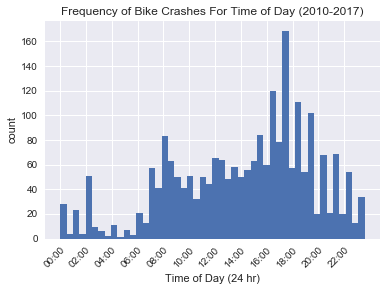

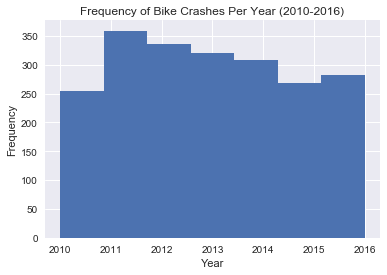

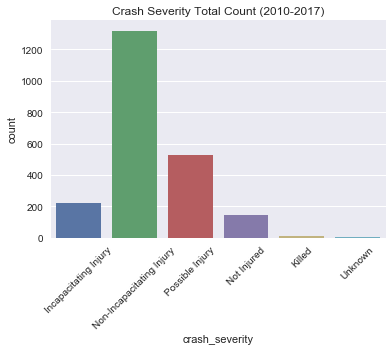

In [14]:
# Let's see the realationship between crashes and time of day
# First, let's just look at the total crashes vs time of day (no crash severity)

data = pd.read_csv("my_map_grid.csv",header=10)
data.columns = data.columns.str.lower()
# remove spaces
data.columns = data.columns.str.replace(' ', '_')

# add 
ax_time = helpers.get_ax_time(
        interval = '24h',
        title = 'Frequency of Bike Crashes For Time of Day (2010-2017)',
        xlabel = 'Time of Day (24 hr)',
        ylabel = 'count',
        )

data.crash_time.hist(bins=48,ax=ax_time)
plt.show()

# Let's see if there is a trend of total bike crashes by year
# We'll ignore 2017 data since it is incomplete
# histogram
if(1):
    data.crash_year[data.crash_year != 2017].plot.hist(bins=7)
    plt.xlabel('Year')
    plt.title('Frequency of Bike Crashes Per Year (2010-2016)')
    plt.show()
# bar chart
else:
    plt.bar(data.crash_year[data.crash_year != 2017].value_counts().index, data.crash_year[data.crash_year != 2017].value_counts().values)
    plt.xlabel('Year')
    plt.title('Frequency of Bike Crashes Per Year (2010-2016)')
    plt.show()

# Spread of Crash Severity data from 2010-2017
# Using seaborn for ease of use with categorical data
sns.countplot(x="crash_severity", data=data);
plt.xticks(rotation=45)
plt.title('Crash Severity Total Count (2010-2017)')
plt.show()


In [72]:
print("Total Crashes involving Severe Injuries and fatalities from 2010-2017")
import IPython
url = 'https://yoinkbird.github.io/crashes.html'
iframe = '<iframe src=' + url + ' width=700 height=525></iframe>'
IPython.display.HTML(iframe)

Total Crashes involving Severe Injuries and fatalities from 2010-2017


# Analysis

## DecisionTree

## XGB - Extreme Gradient Boosting

In [ ]:
# convert 'Wet' 'Dry' to '1' '0'
data['surface_condition'] = data['surface_condition'].factorize()[0]
# DOC: rename col http://stackoverflow.com/a/11346337
data.rename(columns={'surface_condition':'surface_wet'})
# print number of unique
for colname in data.columns:
    print("% 4d : %s" % (len(data[colname].unique()), colname))
# remove data which is has no importance
# better to drop cols with all NaN and convert "unimportant" data to NaN
#  - can't universally decide to drop col just based on uniqueness
# e.g. all of object_struck is 'Not Applicable' and useless, but if surface_condition had only one value "dry" this would be important
# ? for colname in data.columns:
# colname = 'object_struck'
# if(len(data[colname].unique()) == 1):
#   print("-I-: dropping %s for having all homogenous values %s", (colname, data[colname].unique()[0]))
#   data.drop(colname,axis=1,inplace=True)


    

print(data.head())
print(data.info())
if(1):
  data.describe()
  data.hist()
  data.corr().plot() # TODO: seaborn
  plt.show()
else:
  print("-I-: Skipping...")

pairplot_var_list = [
# 'crash_id',
 'average_daily_traffic_amount',
 'average_daily_traffic_year',
 'crash_death_count',
# 'crash_incapacitating_injury_count',
# 'crash_non-incapacitating_injury_count',
# 'crash_not_injured_count',
# 'crash_possible_injury_count',
 'crash_severity',
 'crash_time',
 'crash_year',
 'day_of_week',
# 'intersecting_street_name',
 'intersection_related',
# 'latitude',
 'light_condition',
# 'longitude',
 'manner_of_collision',
 'medical_advisory_flag',
 'number_of_entering_roads',
 'number_of_lanes',
# 'object_struck',
 'road_base_type',
 'speed_limit',
# 'street_name',
 'surface_condition'
 ]

dummies_needed_list = [
 'crash_severity',
 'day_of_week',
 'intersection_related',
 'light_condition',
 'manner_of_collision',
 'number_of_entering_roads',
 'road_base_type',
# 'surface_condition' # factorized
        ]

# tmp disable
if(0):
    sns.pairplot(data, vars=pairplot_var_list)
    plt.show()

# alternative visualisation
datapt = data.pivot_table(values=['crash_death_count','crash_incapacitating_injury_count','crash_non-incapacitating_injury_count'], index=['speed_limit','crash_time'])
print(datapt)

pp.pprint(list(pd.get_dummies(data[dummies_needed_list]).columns))
pp.pprint(list(pd.get_dummies(data[dummies_needed_list]).columns.str.replace('[,\s]+','_').str.lower()))
'''
 'Dark, Lighted', 'dark_lighted_yes'
 'Dark, Not Lighted', 'dark_lighted_no'
 'Dark, Unknown Lighting', 'dark_lighted_unknown'
 'Dawn',
 'Daylight',
 'Dusk',
 'Unknown',
'''

In [ ]:
# print important features
xgb_imp_feats = helpers.print_model_feats_important(model_xgb, x_train.columns)
ax = helpers.get_ax_barh(xgb_imp_feats, title="XGB Important Features")
plt.show()

Confusion matrix, without normalization


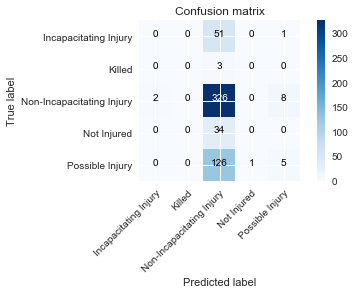

In [31]:
# interpret results
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,model_xgb.predict(x_test))
helpers.plot_confusion_matrix(cm,classes=model_xgb.classes_)

## Random Forest

## KNN: K Nearest Neighbours

# Explainability using DecisionTree

Human-Readable Model
---

The complex model is good for making route predictions.

But what about getting an intuitive feel?

Decision Trees are good for creating explainable models.